The objective to this is to concentrate ourselves to demand forecast with just Blastness dataset and nothing more:
- We have to clean the data provided and see patterns.
- We will compare random forests and prophet neural network.

The idea is to advance more towards HotelRank part of the demand for the moment without data engineering infra to fetch weather and events. 

In [66]:
!pip install bamboolib
!pip install pandas numpy seaborn matplot scikit-learn pyarrow prophet statsmodels
!python -m bamboolib install_nbextensions

Trying to install bamboolib nbextension...
Could not install bamboolib Jupyter Notebook extension because Jupyter Notebook is not available


As first action we load the csv provided by Blastness and we create a dataset with columns names in English

In [67]:

import glob
import pandas as pd
filelist = glob.glob('./hoteldataset/*.csv')
hotelsbookings = []
column_mapping = {
    'Codice': 'Code',
    'Status': 'Status',
    'Canale': 'BookingChannel',
    'Arrivo': 'Arrival',
    'Partenza': 'Departure',
    'Notti': 'Nights',
    'Totale': 'Total',
    'Data acquisto': 'PurchaseDate',
    'Dispositivo': 'BoookingDevice',
    'Data Ultima Modifica/Cancellazione': 'LastModified'
}
for idx,f in enumerate(filelist):
    df = pd.read_csv(f)
    select_columns = list(column_mapping.keys())
    current_df = df[select_columns]
    remap = current_df.rename(columns=column_mapping)
    hotel_id = ""
    if idx < 9:
        hotel_id=f'00{idx+1}'
    else:
        hotel_id=f'0{idx+1}'

    remap['HotelId'] = hotel_id
    hotelsbookings.append(remap)
hotelsbookings[9].head()


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BoookingDevice,LastModified,HotelId
0,GN200KZEYQI1,Confermata,Sito,30/09/2006,01/10/2006,1,"451,00",01/09/2006,Website,01/09/2006 14:11:10,010
1,YR200KTNTGX2,Cancellata,Sito,12/09/2006,13/09/2006,0,"0,00",03/09/2006,Website,03/09/2006 20:33:41,010
2,CD200SIBGGQ5,Confermata,Sito,15/10/2006,17/10/2006,2,"583,00",04/09/2006,Website,04/09/2006 18:35:23,010
3,KL200QSBLYE4,Confermata,Sito,15/10/2006,17/10/2006,2,"583,00",04/09/2006,Website,04/09/2006 18:35:23,010
4,SW200VWGTGG3,Confermata,Sito,15/10/2006,17/10/2006,2,"583,00",04/09/2006,Website,04/09/2006 18:35:23,010


Now we merge all hotels in a single dataframe and save to disk. We note that we need to divide cancelled and confirmed booking. Later since we want do forecast on the confirmed.
- Also we need to categorize the origin
- remove the booking device.

First we merge.

In [68]:
# Merge DataFrames
merged_df = pd.concat(hotelsbookings, ignore_index=True)
# Display the merged DataFrame
print("Merged DataFrame:")
print(merged_df)

Merged DataFrame:
                         Code      Status BookingChannel     Arrival  \
0        178054733/1050553517  Confermata    Booking.com  04/01/2017   
1       1854547257/1135482031  Confermata    Booking.com  10/12/2016   
2       2081545918/1135999314  Cancellata    Booking.com  18/12/2016   
3       1683692499/1137141862  Cancellata    Booking.com  07/12/2016   
4       1683692499/1137141870  Cancellata    Booking.com  07/12/2016   
...                       ...         ...            ...         ...   
151852           XA200DO52912  Confermata           Sito  25/07/2023   
151853           EZ200NJ52913  Confermata           Sito  25/07/2023   
151854           GG200OT52914  Confermata           Sito  26/05/2023   
151855           MG200OY52915  Confermata           Sito  28/06/2023   
151856           QB200WI52916  Confermata           Sito  28/06/2023   

         Departure  Nights    Total PurchaseDate BoookingDevice  \
0       09/01/2017       5  2288,50   01/08/2016  

Ok, we've seen a lot of not known or bad data. Just clean it. We want order by date, in descending mode and take only the last 2 years

In [69]:
merged_df.head()

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BoookingDevice,LastModified,HotelId
0,178054733/1050553517,Confermata,Booking.com,04/01/2017,09/01/2017,5,"2288,50",01/08/2016,NaN,20/12/2016 14:27:05,001
1,1854547257/1135482031,Confermata,Booking.com,10/12/2016,12/12/2016,2,"424,80",19/10/2016,NaN,19/10/2016 22:29:19,001
2,2081545918/1135999314,Cancellata,Booking.com,18/12/2016,20/12/2016,0,"0,00",20/10/2016,NaN,20/10/2016 13:25:40,001
3,1683692499/1137141862,Cancellata,Booking.com,07/12/2016,11/12/2016,0,"0,00",21/10/2016,NaN,21/10/2016 15:48:07,001
4,1683692499/1137141870,Cancellata,Booking.com,07/12/2016,11/12/2016,0,"0,00",21/10/2016,NaN,21/10/2016 15:48:07,001


In [70]:
merged_df['Arrival'] = pd.to_datetime(merged_df['Arrival'])
# Sorting by 'Arrival' column in descending order
sorted_bookings_df = merged_df.sort_values(by='Arrival', ascending=False)
# Filtering for HotelId '001'
filtered_df = sorted_bookings_df.loc[sorted_bookings_df['HotelId'] == '010']
filtered_df.head()

,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BoookingDevice,LastModified,HotelId
151689,EQ200XD52749,Confermata,Sito,2023-12-07,15/07/2023,3,"1663,20",27/11/2022,Website,27/11/2022 07:27:09,010
151017,8357485/1,Confermata,HotelBeds,2023-12-06,15/06/2023,3,"1449,00",22/10/2022,NaN,22/10/2022 00:11:12,010
149939,8233730/1,Cancellata,HotelBeds,2023-12-06,15/06/2023,0,"0,00",14/09/2022,NaN,14/09/2022 16:42:34,010
150810,20022166570845744,Confermata,Galileo,2023-12-06,15/06/2023,3,"1740,00",14/10/2022,NaN,14/10/2022 02:47:37,010
150811,200745166570853524,Confermata,Galileo,2023-12-06,15/06/2023,3,"1350,00",14/10/2022,NaN,14/10/2022 02:48:55,010


Now I convert datates to timestamps

In [71]:
# Filtering for HotelId '001'
nan_rows = sorted_bookings_df[sorted_bookings_df['Arrival'].isna()]
print("Rows with NaN in 'Arrival':", len(nan_rows))
nan_rows = sorted_bookings_df[sorted_bookings_df['Departure'].isna()]
print("Rows with NaN in 'Departure':", len(nan_rows))
# conversion in datetime
sorted_bookings_df['Arrival'] = pd.to_datetime(sorted_bookings_df['Arrival'], errors='coerce', dayfirst=True)
sorted_bookings_df['Departure'] = pd.to_datetime(sorted_bookings_df['Departure'], errors='coerce', dayfirst=True)
sorted_bookings_df['LastModified'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce', dayfirst=True)
sorted_bookings_df['PurchaseDate'] = pd.to_datetime(sorted_bookings_df['PurchaseDate'], errors='coerce', dayfirst=True)
# we want to make sure that are numerical data
sorted_bookings_df['Total'] = sorted_bookings_df['Total'].str.replace(',', '.').astype(float)
sorted_bookings_df['Total'] = pd.to_numeric(sorted_bookings_df['Total'])
sorted_bookings_df['Nights'] = pd.to_numeric(sorted_bookings_df['Nights'])
# add timestamp
sorted_bookings_df['Arrival_Timestamp'] = sorted_bookings_df['Arrival'].astype('int64')
sorted_bookings_df['Departure_Timestamp'] = sorted_bookings_df['Departure'].astype('int64')
sorted_bookings_df['LastModified_Timestamp'] = pd.to_datetime(sorted_bookings_df['LastModified'], errors='coerce')
sorted_bookings_df['Purchase_Timestamp'] = sorted_bookings_df['PurchaseDate'].astype('int64')
sorted_bookings_df.head()



Rows with NaN in 'Arrival': 0
Rows with NaN in 'Departure': 0


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BoookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp
15338,16134HN15330,Confermata,Sito,2024-11-02,2024-02-18,7,3208.0,2023-03-22,Website,2023-03-22 23:03:58,001,1730505600000000000,1708214400000000000,2023-03-22 23:03:58,1679443200000000000
15386,2641625582/4170854126,Confermata,Booking.com,2024-10-02,2024-02-17,7,1968.3,2023-04-01,NaN,2023-04-01 14:17:14,001,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000
15384,3051597195/4170845537,Confermata,Booking.com,2024-10-02,2024-02-17,7,3183.3,2023-04-01,NaN,2023-04-01 14:11:05,001,1727827200000000000,1708128000000000000,2023-04-01 14:11:05,1680307200000000000
15385,2641625582/4170854114,Confermata,Booking.com,2024-10-02,2024-02-17,7,1871.1,2023-04-01,NaN,2023-04-01 14:17:14,001,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000
15656,3379360609/4257615568,Confermata,Booking.com,2024-10-02,2024-02-17,7,5130.0,2023-05-20,NaN,2023-05-20 10:06:11,001,1727827200000000000,1708128000000000000,2023-05-20 10:06:11,1684540800000000000


We want to add the city to he dataset the client has provided the following mapping:
```
hotel_to_city = {
    '001': "Rome, Italu",
    '002': "Naples, Italy",
    '003': "Florence, Italy",
    '004': "Florence, Italy",
    '005': "Naples, Italy",
    '006': "Brindisi, Italy",
    '007': "Latina, Italy",
    '008': "Olbia, Sardinia, Italy",
    '009': "Chamonix-Mont-Blanc, France",
    '010': "Rome, Italy",
}
```
So we can have a complete a dataset to correlate in future with events, weather and so on.

In [72]:
coordinate_to_city = {
    '001': "Rome",
    '002': "Naples",
    '003': "Florence",
    '004': "Florence",
    '005': "Naples",
    '006': "Brindisi",
    '007': "Latina",
    '008': "Olbia",
    '009': "Chamonix-Mont-Blanc",
    '010': "Rome",
}

# Function to get the city name based on HotelId
def get_city(hotel_id):
    return coordinate_to_city.get(hotel_id, "Unknown")

# Add the City column based on the HotelId
sorted_bookings_df['City'] = sorted_bookings_df['HotelId'].apply(get_city)

We want also add the season because we know from the domain the booking changes of season and when the booking device is not known.

In [73]:
# we clean unknown
sorted_bookings_df['BoookingDevice'].fillna('Unknown', inplace=True)
def get_season(date):
    month = date.month
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Fall'
sorted_bookings_df['Season'] = sorted_bookings_df['Arrival'].apply(get_season)
sorted_bookings_df.head()



,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BoookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
15338,16134HN15330,Confermata,Sito,2024-11-02,2024-02-18,7,3208.0,2023-03-22,Website,2023-03-22 23:03:58,001,1730505600000000000,1708214400000000000,2023-03-22 23:03:58,1679443200000000000,Rome,Fall
15386,2641625582/4170854126,Confermata,Booking.com,2024-10-02,2024-02-17,7,1968.3,2023-04-01,Unknown,2023-04-01 14:17:14,001,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000,Rome,Fall
15384,3051597195/4170845537,Confermata,Booking.com,2024-10-02,2024-02-17,7,3183.3,2023-04-01,Unknown,2023-04-01 14:11:05,001,1727827200000000000,1708128000000000000,2023-04-01 14:11:05,1680307200000000000,Rome,Fall
15385,2641625582/4170854114,Confermata,Booking.com,2024-10-02,2024-02-17,7,1871.1,2023-04-01,Unknown,2023-04-01 14:17:14,001,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000,Rome,Fall
15656,3379360609/4257615568,Confermata,Booking.com,2024-10-02,2024-02-17,7,5130.0,2023-05-20,Unknown,2023-05-20 10:06:11,001,1727827200000000000,1708128000000000000,2023-05-20 10:06:11,1684540800000000000,Rome,Fall


Now before going further and doing descriptive statistics we neeed to know is there are still NaN. It is ok we store for future purposes the dataset in parquet file. 

In [74]:
# Check if any row in any column is NaN
has_nan = sorted_bookings_df.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
# Display rows with any NaN values
rows_with_nan = sorted_bookings_df[sorted_bookings_df.isna().any(axis=1)]
print("Rows with NaN values:")
rows_with_nan.head()


Does the DataFrame contain any NaN values? True
Rows with NaN values:


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BoookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
47435,RDK00025294-SE,Cancellata,NaN,2023-12-07,2023-07-15,0,0.00,2023-06-25,Unknown,2023-06-25 18:42:22,003,1701907200000000000,1689379200000000000,2023-06-25 18:42:22,1687651200000000000,Florence,Winter
47434,RDK00025294-SE,Confermata,NaN,2023-12-07,2023-07-15,3,656.64,2023-06-25,Unknown,2023-06-25 18:42:22,003,1701907200000000000,1689379200000000000,2023-06-25 18:42:22,1687651200000000000,Florence,Winter
46886,RDK00014771-A35343-25660-13565848-Secret Escapes,Confermata,NaN,2023-12-05,2023-05-17,5,1257.22,2023-04-12,Unknown,2023-04-12 15:58:19,003,1701734400000000000,1684281600000000000,2023-04-12 15:58:19,1681257600000000000,Florence,Winter
46867,RDK00014459-A35343-21410-13541714-Secret Escapes,Cancellata,NaN,2023-12-05,2023-05-13,0,0.00,2023-04-10,Unknown,2023-04-10 19:52:26,003,1701734400000000000,1683936000000000000,2023-04-10 19:52:26,1681084800000000000,Florence,Winter
46866,RDK00014459-A35343-21410-13541714-Secret Escapes,Confermata,NaN,2023-12-05,2023-05-13,1,199.68,2023-04-10,Unknown,2023-04-10 19:52:26,003,1701734400000000000,1683936000000000000,2023-04-10 19:52:26,1681084800000000000,Florence,Winter


Ok. We've seen that the booking channel can be a valid string or Unknown. The other thing that we want is to the hotel booking for a fixed period from 2024 to 2022. After this we can 

In [75]:
sorted_bookings_df['BookingChannel'] = sorted_bookings_df['BookingChannel'].fillna('Unknown')
sorted_bookings_df.head()


,Code,Status,BookingChannel,Arrival,Departure,Nights,Total,PurchaseDate,BoookingDevice,LastModified,HotelId,Arrival_Timestamp,Departure_Timestamp,LastModified_Timestamp,Purchase_Timestamp,City,Season
15338,16134HN15330,Confermata,Sito,2024-11-02,2024-02-18,7,3208.0,2023-03-22,Website,2023-03-22 23:03:58,001,1730505600000000000,1708214400000000000,2023-03-22 23:03:58,1679443200000000000,Rome,Fall
15386,2641625582/4170854126,Confermata,Booking.com,2024-10-02,2024-02-17,7,1968.3,2023-04-01,Unknown,2023-04-01 14:17:14,001,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000,Rome,Fall
15384,3051597195/4170845537,Confermata,Booking.com,2024-10-02,2024-02-17,7,3183.3,2023-04-01,Unknown,2023-04-01 14:11:05,001,1727827200000000000,1708128000000000000,2023-04-01 14:11:05,1680307200000000000,Rome,Fall
15385,2641625582/4170854114,Confermata,Booking.com,2024-10-02,2024-02-17,7,1871.1,2023-04-01,Unknown,2023-04-01 14:17:14,001,1727827200000000000,1708128000000000000,2023-04-01 14:17:14,1680307200000000000,Rome,Fall
15656,3379360609/4257615568,Confermata,Booking.com,2024-10-02,2024-02-17,7,5130.0,2023-05-20,Unknown,2023-05-20 10:06:11,001,1727827200000000000,1708128000000000000,2023-05-20 10:06:11,1684540800000000000,Rome,Fall


Now I want to restrict the timing interval between 2020 and 2024.

In [76]:
start_date = '2020-01-01'
end_date = '2024-02-28'
sorted_bookings_df.head()
datetime_columns = ['Arrival', 'Departure', 'PurchaseDate', 'LastModified']
for col in datetime_columns:
    sorted_bookings_df[col] = pd.to_datetime(sorted_bookings_df[col])
hb_dataset = sorted_bookings_df[(sorted_bookings_df['Arrival'] >= start_date) & (sorted_bookings_df['Arrival'] <= end_date)] 
# Check if any row in any column is NaN
has_nan = hb_dataset.isna().any().any()
print(f"Does the DataFrame contain any NaN values? {has_nan}")
if has_nan:
# Display rows with any NaN values
    rows_with_nan = hb_dataset[hb_dataset.isna().any(axis=1)]
    print("Rows with NaN values:")
    rows_with_nan.head()
else:
    print('The dataset is ready some descriptivre statistics')

Does the DataFrame contain any NaN values? False
The dataset is ready some descriptivre statistics


In [77]:
# Save the filtered DataFrame to a Parquet file
parquet_file = 'filtered_data.parquet'
hb_dataset.to_parquet(parquet_file)
print(f"Filtered DataFrame saved to {parquet_file}")

Filtered DataFrame saved to filtered_data.parquet


In [78]:
# For numeric columns only
descriptive_stats = hb_dataset.describe()
print("\nDescriptive Statistics for numeric columns in the filtered DataFrame:")
print(descriptive_stats)
descriptive_stats_all = hb_dataset.describe(include='all')
print("\nDescriptive Statistics for all columns in the filtered DataFrame:")
print(descriptive_stats_all)


Descriptive Statistics for numeric columns in the filtered DataFrame:
             Nights         Total  Arrival_Timestamp  Departure_Timestamp  \
count  39375.000000  39375.000000       3.937500e+04         3.937500e+04   
mean       1.517663    396.484267       1.641716e+18         1.642539e+18   
std        1.969103    668.298718       3.285898e+16         3.243173e+16   
min        0.000000      0.000000       1.577837e+18         1.577923e+18   
25%        0.000000      0.000000       1.615853e+18         1.622938e+18   
50%        1.000000    144.900000       1.649549e+18         1.651363e+18   
75%        2.000000    531.515000       1.665014e+18         1.664323e+18   
max       30.000000  20124.000000       1.708733e+18         1.709856e+18   

       Purchase_Timestamp  
count        3.937500e+04  
mean         1.636303e+18  
std          3.340110e+16  
min          1.553213e+18  
25%          1.612829e+18  
50%          1.645229e+18  
75%          1.661299e+18  
max        

We know that:
- We've 39375 booking in the period.
- The average staying is 1.6 days for each booking.
- The medium booking revenue is 370 euros.
That's not enough, we want to know:
- How frequent is a booking?
- Which between our customers how had most revenue?
- Which has most room booked and and in which city?
- Which is the season in which we've most rooom booked? 

In [79]:
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

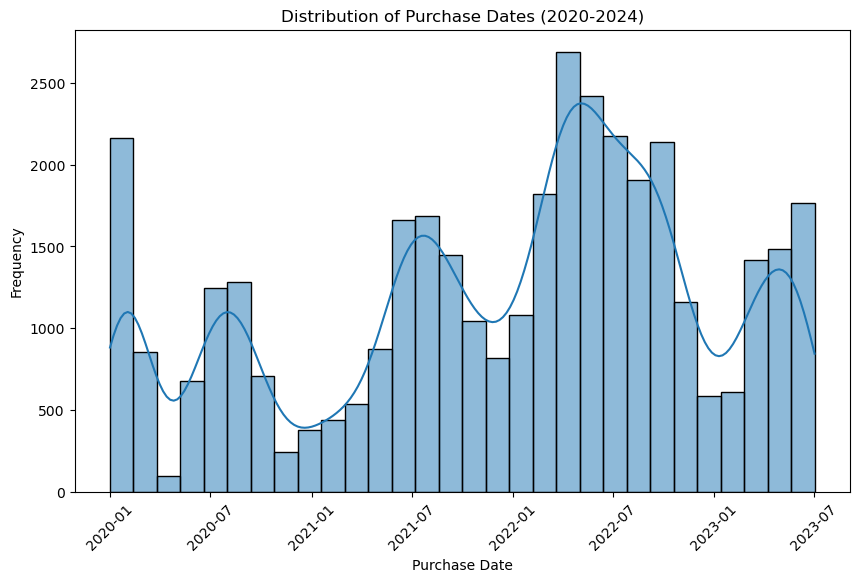

In [80]:
start_date = '2020-01-01'
end_date = '2024-12-31'
filtered_df = hb_dataset[(hb_dataset['PurchaseDate'] >= start_date) & (hb_dataset['PurchaseDate'] <= end_date)]

# Plot the distribution of purchase dates using Seaborn
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['PurchaseDate'], kde=True, bins=30)
plt.xlabel('Purchase Date')
plt.ylabel('Frequency')
plt.title('Distribution of Purchase Dates (2020-2024)')
plt.xticks(rotation=45)
plt.show()

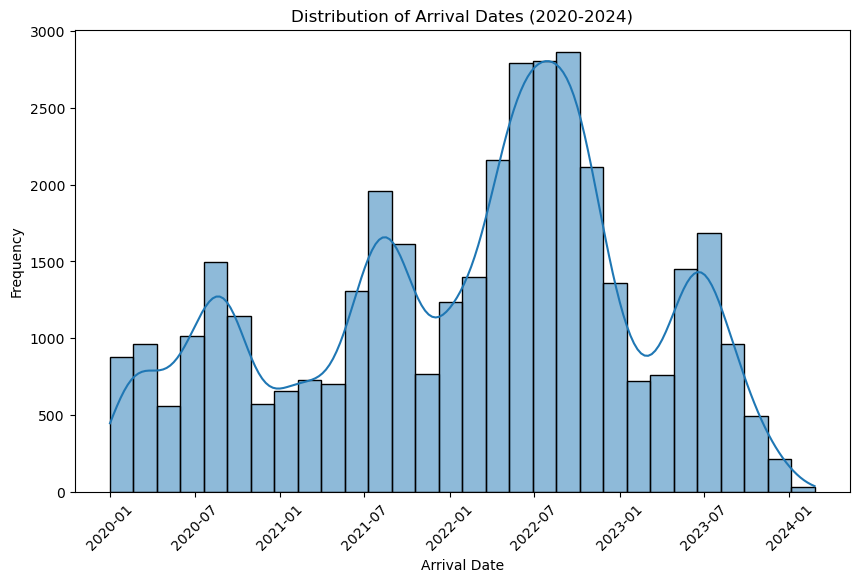

In [81]:
plt.figure(figsize=(10, 6))
sns.histplot(filtered_df['Arrival'], kde=True, bins=30)
plt.xlabel('Arrival Date')
plt.ylabel('Frequency')
plt.title('Distribution of Arrival Dates (2020-2024)')
plt.xticks(rotation=45)
plt.show()

Make sense. Most booking are at the beginning of the year and just before summer. Italians tends to go in vacation on August so in July the book.

  Distribution  KS Statistic  P-Value
0         norm      0.106229      0.0
1        expon      0.277968      0.0
2        gamma      0.115443      0.0
3      lognorm      0.106231      0.0
4         beta      0.137417      0.0


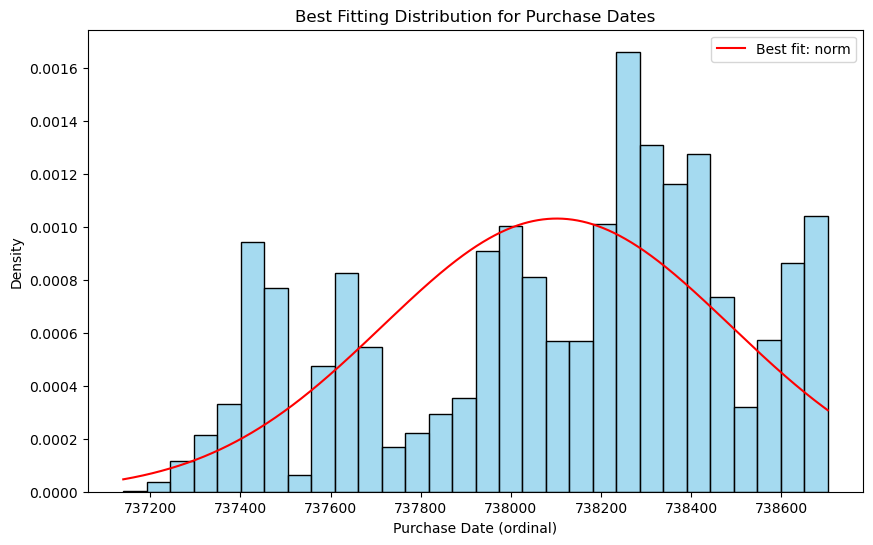

In [82]:
# Convert 'PurchaseDate' to ordinal for fitting distributions
purchase_dates = hb_dataset['PurchaseDate'].apply(lambda x: x.toordinal())

# List of distributions to check
distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

# Fit distributions and calculate KS statistic
results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(purchase_dates)
    ks_stat, p_value = stats.kstest(purchase_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

# Print results
results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

# Plot the best fitting distribution
best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(purchase_dates)

# Plot histogram and fitted distribution
plt.figure(figsize=(10, 6))
sns.histplot(purchase_dates, kde=False, bins=30, color='skyblue', stat='density')

# Plot the PDF of the best fitting distribution
x = np.linspace(min(purchase_dates), max(purchase_dates), 1000)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Purchase Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Purchase Dates')
plt.legend()
plt.show()


  Distribution  KS Statistic  P-Value
0         norm      0.097109      0.0
1        expon      0.229352      0.0
2        gamma      0.106320      0.0
3      lognorm      0.097113      0.0
4         beta      0.101880      0.0


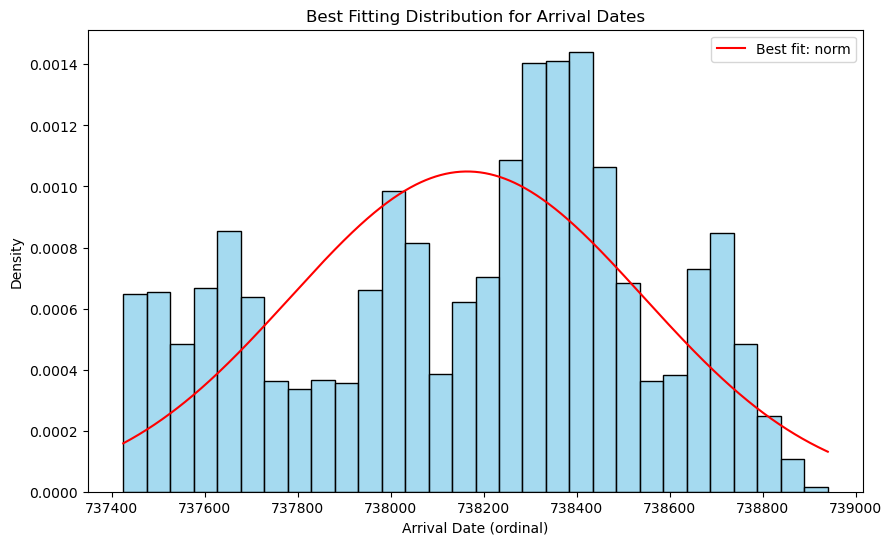

In [83]:
arrival_dates = hb_dataset['Arrival'].apply(lambda x: x.toordinal())

# List of distributions to check
distributions = ['norm', 'expon', 'gamma', 'lognorm', 'beta']

# Fit distributions and calculate KS statistic
results = []
for dist_name in distributions:
    dist = getattr(stats, dist_name)
    params = dist.fit(arrival_dates)
    ks_stat, p_value = stats.kstest(arrival_dates, dist_name, args=params)
    results.append((dist_name, ks_stat, p_value))

# Print results
results_df = pd.DataFrame(results, columns=['Distribution', 'KS Statistic', 'P-Value'])
print(results_df)

# Plot the best fitting distribution
best_dist_name = results_df.sort_values('KS Statistic').iloc[0]['Distribution']
best_dist = getattr(stats, best_dist_name)
best_params = best_dist.fit(arrival_dates)

# Plot histogram and fitted distribution
plt.figure(figsize=(10, 6))
sns.histplot(arrival_dates, kde=False, bins=30, color='skyblue', stat='density')

# Plot the PDF of the best fitting distribution
x = np.linspace(min(arrival_dates), max(arrival_dates), 1000)
pdf_fitted = best_dist.pdf(x, *best_params)
plt.plot(x, pdf_fitted, 'r-', label=f'Best fit: {best_dist_name}')

plt.xlabel('Arrival Date (ordinal)')
plt.ylabel('Density')
plt.title('Best Fitting Distribution for Arrival Dates')
plt.legend()
plt.show()

## Which between our customers had most revenue?

In [84]:

revenue_per_hotel = hb_dataset.groupby(['HotelId', 'City'])['Total'].sum().reset_index()
revenue_per_hotel.sort_values(['Total'], inplace=True, ascending=False)
revenue_per_hotel.head()


,HotelId,City,Total
9,010,Rome,6398486.80
0,001,Rome,2444247.45
8,009,Chamonix-Mont-Blanc,1808414.24
4,005,Naples,1606252.54
2,003,Florence,1545058.55


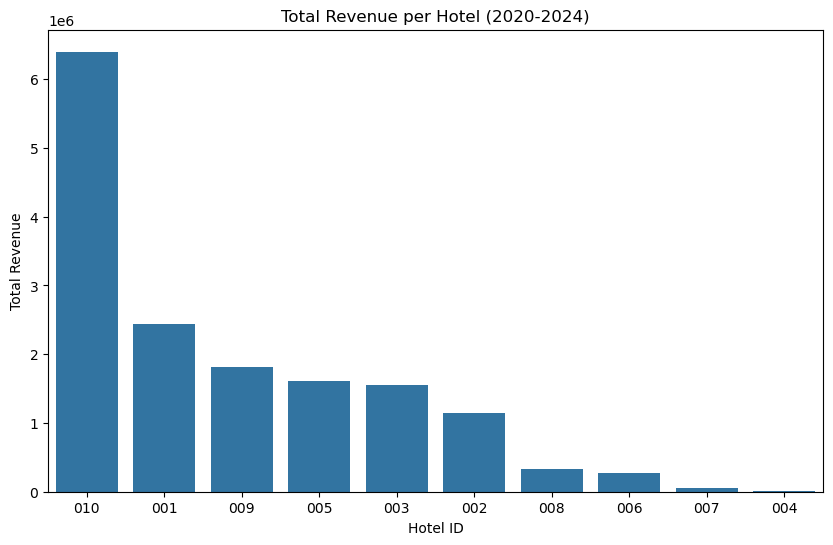

In [85]:
plt.figure(figsize=(10, 6))
sns.barplot(x='HotelId', y='Total', data=revenue_per_hotel)
plt.xlabel('Hotel ID')
plt.ylabel('Total Revenue')
plt.title('Total Revenue per Hotel (2020-2024)')
plt.show()

Now we want to see in the dataset the correlation between data, but for doing this and reaching the correlation matrix we need to reduce the 
features, distiguish between categorical and numerical and doing one shot encoding, removing redundant features.

In [86]:

# Identify numerical and categorical columns
numerical_cols = hb_dataset.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = hb_dataset.select_dtypes(include=['object']).columns
# Drop unnecessary columns
corr_df = hb_dataset.drop(columns=['Code', 'Arrival', 'Departure', 'PurchaseDate', 'LastModified'])
# One-hot encoding of categorical columns using pd.get_dummies
df_encoded = pd.get_dummies(corr_df, drop_first=True)
# Compute the correlation matrix
correlation_matrix = df_encoded.corr()
# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

Correlation Matrix:
                       Nights     Total  Arrival_Timestamp  \
Nights               1.000000  0.794819           0.157279   
Total                0.794819  1.000000           0.195146   
Arrival_Timestamp    0.157279  0.195146           1.000000   
Departure_Timestamp  0.159794  0.200883           0.975974   
Purchase_Timestamp   0.173974  0.207489           0.955155   
...                       ...       ...                ...   
City_Olbia           0.006874 -0.034286          -0.068688   
City_Rome           -0.066843  0.082326          -0.066603   
Season_Spring       -0.048817 -0.052944          -0.053329   
Season_Summer        0.067006  0.039499           0.045661   
Season_Winter       -0.018038 -0.010610          -0.120472   

                     Departure_Timestamp  Purchase_Timestamp  \
Nights                          0.159794            0.173974   
Total                           0.200883            0.207489   
Arrival_Timestamp               0.975974   

As expected some things are evident:
- Rome is the city with higher possible revenue having an high correlation with Price.
- Purchase Date and Arrival Date are correlated.
Less evident is the behaviour for Season and the cities:
- Expected behaviour that Olbia is overcrowded in Summer, since it is in Sardinia. Probabally another cleaning iteration is needed here.
For our purpose, compute demandscore is enough since we select just Arrival and treat the dataset like a time series.
Now we will focus in model selection based on Arrival since our goal is to compute the demand score per hotel.
There are two algorithms:
    - Prophet
    - SARIMAX

We'll see which is the best one for this dataset and we compute the score.


In [87]:
import pandas as pd
import numpy as np
from prophet import Prophet
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

warnings.filterwarnings("ignore")


# Aggregate the data to get weekly demand
hb_dataset['Week'] = hb_dataset['Arrival'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_demand = hb_dataset.groupby('Week').size().reset_index(name='Demand')
weekly_demand.head()




,Week,Demand
0,2019-12-30,123
1,2020-01-06,277
2,2020-01-13,99
3,2020-01-20,130
4,2020-01-27,229


In [88]:

# Prepare the data for Prophet
weekly_demand_prophet = weekly_demand.rename(columns={'Week': 'ds', 'Demand': 'y'})

# Fit Prophet model
prophet_model = Prophet()
prophet_model.fit(weekly_demand_prophet)

# Make a future dataframe for Prophet
future_prophet = prophet_model.make_future_dataframe(periods=52, freq='W')
forecast_prophet = prophet_model.predict(future_prophet)



23:33:12 - cmdstanpy - INFO - Chain [1] start processing
23:33:12 - cmdstanpy - INFO - Chain [1] done processing


In [89]:
weekly_demand_prophet.head()

,ds,y
0,2019-12-30,123
1,2020-01-06,277
2,2020-01-13,99
3,2020-01-20,130
4,2020-01-27,229


In [90]:
forecast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2019-12-30,151.725184,-27.414029,210.411871,151.725184,151.725184,-62.430717,-62.430717,-62.430717,-62.430717,-62.430717,-62.430717,0.0,0.0,0.0,89.294467
1,2020-01-06,152.363068,-14.976682,211.609716,152.363068,152.363068,-58.678373,-58.678373,-58.678373,-58.678373,-58.678373,-58.678373,0.0,0.0,0.0,93.684695
2,2020-01-13,153.000953,-10.408364,212.178423,153.000953,153.000953,-54.237780,-54.237780,-54.237780,-54.237780,-54.237780,-54.237780,0.0,0.0,0.0,98.763172
3,2020-01-20,153.638837,-18.508700,207.924494,153.638837,153.638837,-58.375776,-58.375776,-58.375776,-58.375776,-58.375776,-58.375776,0.0,0.0,0.0,95.263061
4,2020-01-27,154.276721,-23.914260,202.803986,154.276721,154.276721,-65.181438,-65.181438,-65.181438,-65.181438,-65.181438,-65.181438,0.0,0.0,0.0,89.095284


In [91]:
# Fit ARIMA model
arima_model = SARIMAX(weekly_demand['Demand'], order=(1, 1, 1), seasonal_order=(1, 1, 1, 52))
arima_model_fit = arima_model.fit(disp=False)
# Forecast using ARIMA
forecast_arima = arima_model_fit.get_forecast(steps=52)
forecast_arima_df = forecast_arima.summary_frame()


In [92]:
# Prepare the forecast data for comparison
forecast_prophet = forecast_prophet[['ds', 'yhat']].set_index('ds')
forecast_arima_df = forecast_arima_df[['mean']]


In [93]:

# Compute evaluation metrics
# For Prophet
prophet_true = weekly_demand['Demand'].values[-52:]
prophet_pred = forecast_prophet['yhat'].values[:52]
prophet_mae = mean_absolute_error(prophet_true, prophet_pred)
prophet_mse = mean_squared_error(prophet_true, prophet_pred)
prophet_rmse = np.sqrt(prophet_mse)

# For ARIMA
arima_true = weekly_demand['Demand'].values[-52:]
arima_pred = forecast_arima_df['mean'].values[:52]
arima_mae = mean_absolute_error(arima_true, arima_pred)
arima_mse = mean_squared_error(arima_true, arima_pred)
arima_rmse = np.sqrt(arima_mse)

# Print evaluation metrics
print(f"Prophet MAE: {prophet_mae}, MSE: {prophet_mse}, RMSE: {prophet_rmse}")
print(f"ARIMA MAE: {arima_mae}, MSE: {arima_mse}, RMSE: {arima_rmse}")


Prophet MAE: 97.22875881839182, MSE: 13989.777902305872, RMSE: 118.27839152738709
ARIMA MAE: 103.55959060112583, MSE: 13553.634110175268, RMSE: 116.42007606154219


# Performance
Better SARIMA. So we will use SARIMA for the compute of the score based on arrival. Let's motivate the process:
- Mean Average Error (MSE): Tells us the average magnitude of the forecast errors. 
- Mean Square Error: Emphasizes larger errors more than MAE. 
- Root Mean Square Error: Provides an error measure in the same units as the demand. 

## Comparing Models
- SARIMA shows an higher MAE than Prophet but perform better since MSE and RMSE are lower.
# Conclusion
We conclude this  assignment with the decision of using SARIMA as algorithm for computing the DemandScore based on Arrival. The process of cleaning
has produced a dataset in Parquet that we can use.